# Problem Statement
- Analyse Fake.csv & True.csv
- Combine both the csv
- Pre-process text description
- Vectorize the text using TF-IDF and Count Vectorizer
- Train NB Model
- Evaluate the model using precision, recall, f1 score


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

from nltk.corpus import stopwords    
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from utils import *
import joblib

In [2]:
warnings.filterwarnings("ignore")
# pd.set_option("display.max_rows", 100)
# pd.set_option("display.max_columns", 100)

In [3]:
true_df = pd.read_csv("./True.csv")
fake_df = pd.read_csv("./Fake.csv")

# Dataset Analysis 
- Combine both the CSVs
- `True` and `Fake` will be considered as target labels 
- `Text` column dominates the dataset
- `Date` and `subject` column can be droped as the problem statement is much more aligned towards text analysis
- `Title` summaizes the descriptive information of news


## Processing (Merge & Update)
- Perform text cleaning on `Text` column
- Convert `True` and `Fake` values into binary categories
- drop `date` & `subject` column

In [4]:
true_df["Target"] = 1
fake_df["Target"] = 0

In [5]:
df_merged = pd.concat([true_df, fake_df], axis=0)

In [6]:
df_merged.drop(["date", "subject"], axis=1, inplace=True)

## Pre-processing
- count `title` & `text` information and create new column
- drop duplicate rows

In [7]:
df_merged["title_word_count"] = df_merged.title.str.lower().apply(lambda x: len(x.split()))
df_merged["text_word_count"] = df_merged.text.str.lower().apply(lambda x: len(x.split()))

In [8]:
df_merged.drop_duplicates(inplace=True)

In [9]:
df_merged.sample(10)

,title,text,Target,title_word_count,text_word_count
14542,Italy holds funeral for 26 Nigerian women drow...,"SALERNO, Italy (Reuters) - Italy held a mass f...",1,10,321
15384,ZIMBABWE’S CORRUPT GOVERNMENT SEEKS EXTRADITIO...,So much outrage by so many corrupt people it s...,0,21,1808
9776,U.S. top court poised to overturn Virginia ex-...,WASHINGTON (Reuters) - The U.S. Supreme Court ...,1,10,797
10963,ELLEN Just Proved She’s A HUGE Hypocrite And K...,Someone needs to educate Ellen DeGeneres on Pr...,0,13,253
10112,Trump in unexpected meeting with Republican Pa...,WASHINGTON (Reuters) - U.S. Republican preside...,1,8,91
14021,MILLENNIAL Drops Awesome TRUTH BOMB On Her Gen...,One millennial is 100% FED Up! with her genera...,0,23,194
887,Fox News Gives The Most Cringeworthy Reason W...,"Donald Trump and his favorite daughter, Ivanka...",0,16,333
10289,Republican Ryan rejects Trump warning of riots...,WASHINGTON (Reuters) - U.S. House of Represent...,1,10,89
4785,Trump budget on the menu as U.S. senators lunc...,WASHINGTON (Reuters) - The U.S. Senate Foreign...,1,11,406
10166,"As tensions escalate, Cruz calls Trump a 'sniv...",WASHINGTON (Reuters) - The feud between Republ...,1,9,709


## Describe and Analyse the word counts 
- Top 13 and 869 word length frequencies explains <b>95%</b> of `title` and  `text`
- `text` have high bais below 10% and above 99%
- To have fair distribution in `text` we can remove data below word length 30 and above 1500 to reduce dominancy
- Similarly we can remove data from `title` where title length is less than 4

In [10]:
df_merged = df_merged[(df_merged["text_word_count"] != 0) & (df_merged["title_word_count"] != 0)]

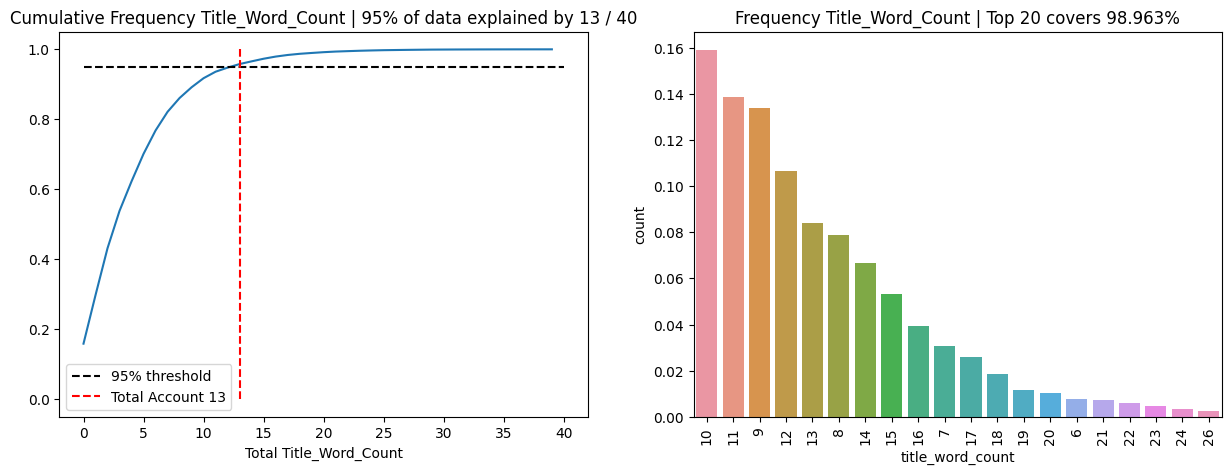

In [11]:
_ = frequencyPlot(df_merged["title_word_count"], 
              "title_word_count", 
              percent=95, 
              total_top_class=20)

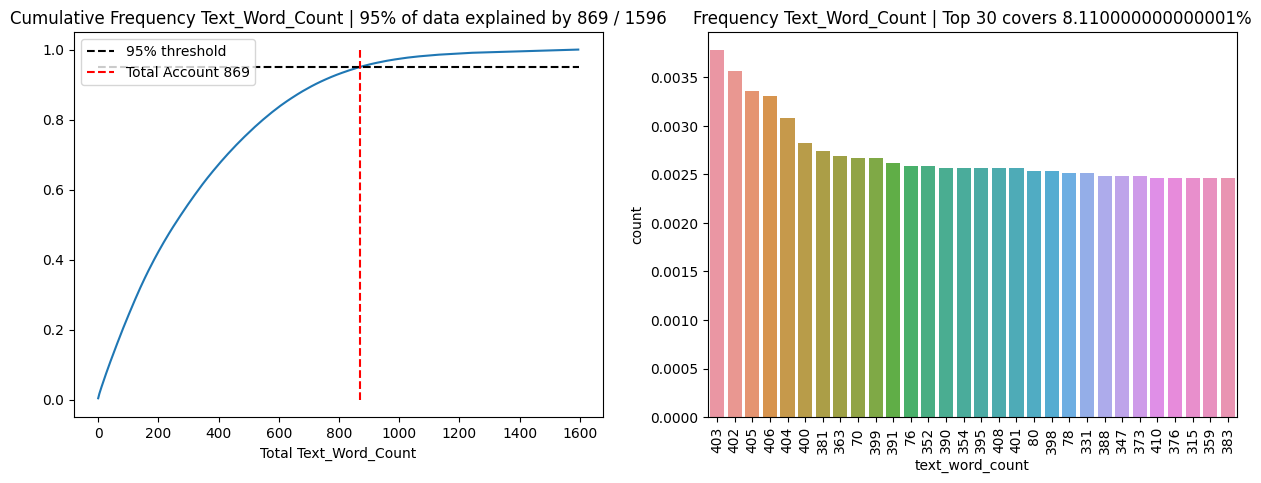

In [12]:
_ = frequencyPlot(df_merged["text_word_count"], 
              "text_word_count", 
              percent=95, 
              total_top_class=30)

In [13]:
df_merged[["text_word_count", "title_word_count"]].describe(percentiles=[0.01,.1,.25,.50,.75,.90,.99])

,text_word_count,title_word_count
count,38658.000000,38658.000000
mean,403.130659,11.924543
std,313.868903,3.658152
min,1.000000,1.000000
1%,20.000000,6.000000
10%,86.000000,8.000000
25%,216.000000,9.000000
50%,369.000000,11.000000
75%,511.000000,14.000000
90%,734.000000,16.000000


In [14]:
df = df_merged[(df_merged.title_word_count>4) & (df_merged.text_word_count>30) & (df_merged.text_word_count<1500)]

In [15]:
df.shape

(37710, 5)

# Text Cleaning
- Remove Punctuations, stopwords (english), and URLs
- Perform Word lemmitization
- Remove extra Spaces
- Retaining `.` if it comes between the words because this can make good impact on contextual meaning

In [16]:
clean_df = pd.DataFrame()

In [17]:
clean_df["text"] = df.text.apply(clean_text)
clean_df["title"] = df.title.apply(clean_text)

In [18]:
clean_df["title_word_count"] = clean_df.title.apply(lambda x : len(x.split()))
clean_df["text_word_count"] = clean_df.text.apply(lambda x : len(x.split()))

In [19]:
clean_df.sample(10)

,text,title,title_word_count,text_word_count
735,beijing reuters china united state created mir...,china u.s create miracle 253.4 billion dealmak...,8,40
10724,word nothingburger tossed around much lately b...,every bad thing say goodbye exit paris accord,8,331
258,trump administration ongoing war lgbtq communi...,justice department said legal discriminate tra...,7,206
14805,caracas reuters venezuela opposition said tues...,venezuela opposition say talk government delayed,6,173
19695,rome reuters italy antiestablishment 5star mov...,5stars young popular di maio chart course ital...,9,405
2122,reuters wisconsin republicancontrolled state a...,wisconsin bill giving 3 billion incentive foxc...,8,255
8063,come this.on tuesday msnbc announced would org...,msnbc shock viewer announcing prime time town ...,12,398
22052,21st century wire say everyone busy hyping nor...,tillerson north korea enemy u seek dialogue re...,9,326
2894,washington reuters head u.s office government ...,u.s official confronted trump ethic resigning ...,8,231
16372,moscow reuters russian president vladimir puti...,russia putin urge tough action online extremism,7,55


- Data description seen fairly well and distributed

In [20]:
clean_df[["text_word_count", "title_word_count"]].describe(percentiles=[0.01,.1,.25,.50,.75,.90,.99])

,text_word_count,title_word_count
count,37710.000000,37710.000000
mean,229.290586,9.066773
std,141.571791,2.409495
min,10.000000,2.000000
1%,27.000000,5.000000
10%,57.000000,7.000000
25%,132.000000,8.000000
50%,212.000000,9.000000
75%,293.000000,10.000000
90%,422.000000,12.000000


- Creating vocabulary by combining all the words and by tokenizing them
- <b>21911</b> words can explain <b>95%</b> of the text information
- Top <b>30%</b> words are good to go with 12% of the data
- Mojorly `text` is trying to talk about USA
- <b>We can remove all the low frequecy words for better results and faster computation</b>

In [21]:
text_words = pd.DataFrame({"words":' '.join(clean_df.text.values).split()})

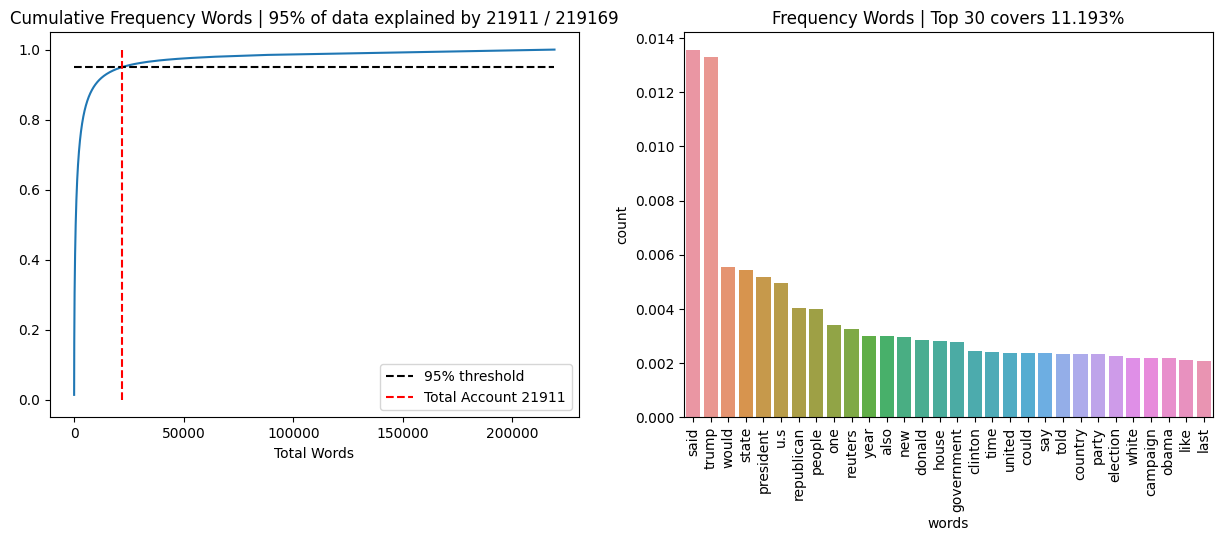

In [22]:
boolean_index, column_values, total_data_size = frequencyPlot(text_words["words"], 
                                                              "words", 
                                                              percent=95, 
                                                              total_top_class=30)

In [23]:
stopwords_list = list(set(text_words[~boolean_index].words.values))
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
tfidf_matrix = vectorizer.fit_transform(clean_df["text"].values)

In [68]:
count_vectorizer = CountVectorizer(stop_words=stopwords_list)
cv_matrix = count_vectorizer.fit_transform(clean_df["text"].values)

In [88]:
print("TF-IDF Vectorizer")
print("Before in data stopwords removal: ",len(set(text_words.words.values)))
print("After in data stopwords removal: ",vectorizer.get_feature_names_out().shape[0])

TF-IDF Vectorizer
Before in data stopwords removal:  219169
After in data stopwords removal:  150117


In [74]:
print("Count Vectorizer")
print("Before in data stopwords removal: ",len(set(text_words.words.values)))
print("After in data stopwords removal: ",cv_matrix.shape[1])

Count Vectorizer
Before in data stopwords removal:  219169
After in data stopwords removal:  29456


In [25]:
tfidf_matrix.toarray().shape

(37710, 29456)

In [29]:
29456*.02

589.12

In [30]:
svd = TruncatedSVD(3000)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

In [42]:
svd.explained_variance_ratio_.sum()

0.29293975287994545

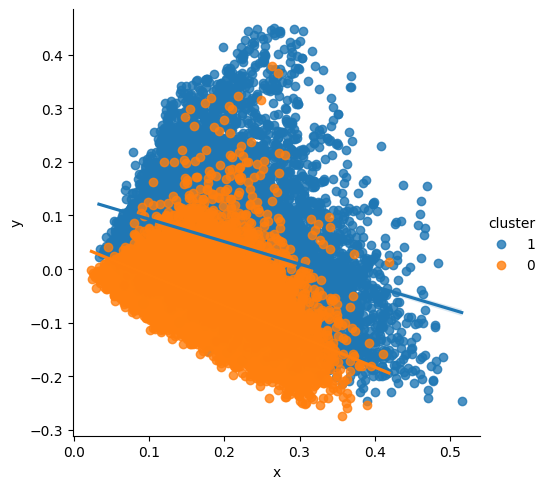

In [38]:
pca_df = pd.DataFrame(reduced_tfidf[:,:3], columns=["x", "y","z"])
pca_df['cluster'] = df["Target"].astype("str").values
sns.lmplot(x="x",y="y", data=pca_df, hue="cluster", fit_reg=True)

In [39]:
import plotly.express as px

In [40]:
fig = px.scatter_3d(pca_df.sample(10000), x='x', y='y', z='z',
              color='cluster')
fig.show()

# TF-IDF Vectorizer model
- Performed training on MultinomialNB and DecisionTree
- Model performed very well on both

## Model Hyperparameter
- Train Test split will be 80:20
- Selected models are `MultinomialNB`


In [89]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df.Target, test_size=0.20, random_state=42)

In [90]:
# Multinomial Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test)

In [91]:
X_train_pred = clf.predict(X_train)
X_test_pred = clf.predict(X_test)
X_train_pred_prob = clf.predict_proba(X_train)
X_test_pred_prob = clf.predict_proba(X_test)

In [92]:
from sklearn.metrics import roc_curve, auc

- Test and Train threshold is quite similar in both the datasets
- We can use `Train` threshold for further prediction for deployment
- F1 score for both training and testing works well

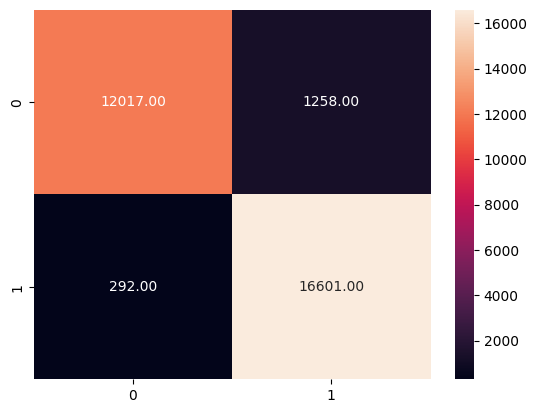

In [100]:
_=sns.heatmap(confusion_matrix(y_train, X_train_pred), annot=True, fmt='.2f')

Test F1 Score:  0.9496436499591073  | Train F1 Score:  0.953501367606835
Test ROC AUC Score:  0.9404746027294448  | Train ROC AUC Score:  0.9459615506171948
Test Precision Score:  0.9396531791907514  | Train Precision Score:  0.947509936871639
Test Recall Score:  0.9598488427019367  | Train Recall Score:  0.9595690522701711
Test Threshold:  0.5341478271896404
Train Threshold:  0.5645671648175852


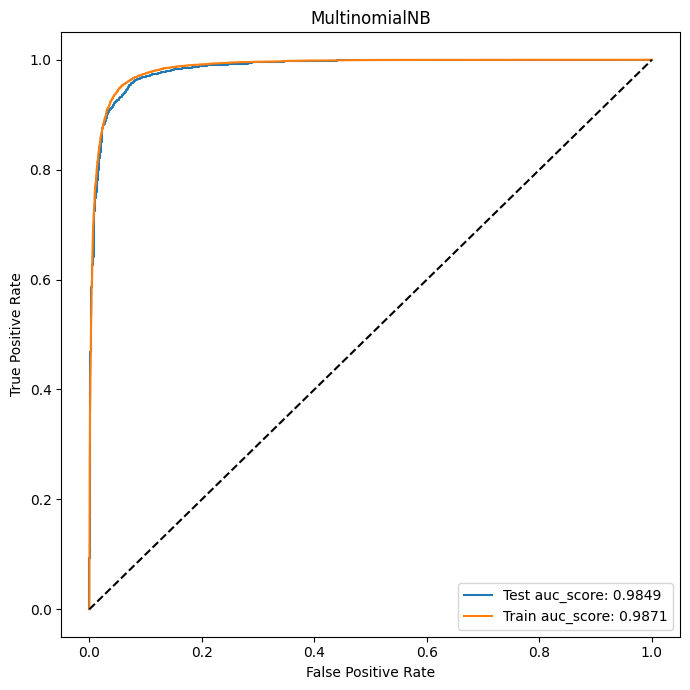

In [58]:
check_metric(y_train, X_train_pred, X_train_pred_prob, 
             y_test, X_test_pred, X_test_pred_prob, 
             title="MultinomialNB")

In [59]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
DT_clf = DecisionTreeClassifier()

In [61]:
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [62]:
DT_y_pred = DT_clf.predict(X_test)

In [64]:
DT_X_train_pred = DT_clf.predict(X_train)
DT_X_test_pred = DT_clf.predict(X_test)
DT_X_train_pred_prob = DT_clf.predict_proba(X_train)
DT_X_test_pred_prob = DT_clf.predict_proba(X_test)

- Test and train threshold is 1.0 which means that the decision tree model itself is predicting the class
- Decision tree metrics shows that the model model could be highly bias

Test F1 Score:  0.9945665012993149  | Train F1 Score:  1.0
Test ROC AUC Score:  0.9938405285935985  | Train ROC AUC Score:  1.0
Test Precision Score:  0.9948015122873346  | Train Precision Score:  1.0
Test Recall Score:  0.9943316013226263  | Train Recall Score:  1.0
Test Threshold:  1.0
Train Threshold:  1.0


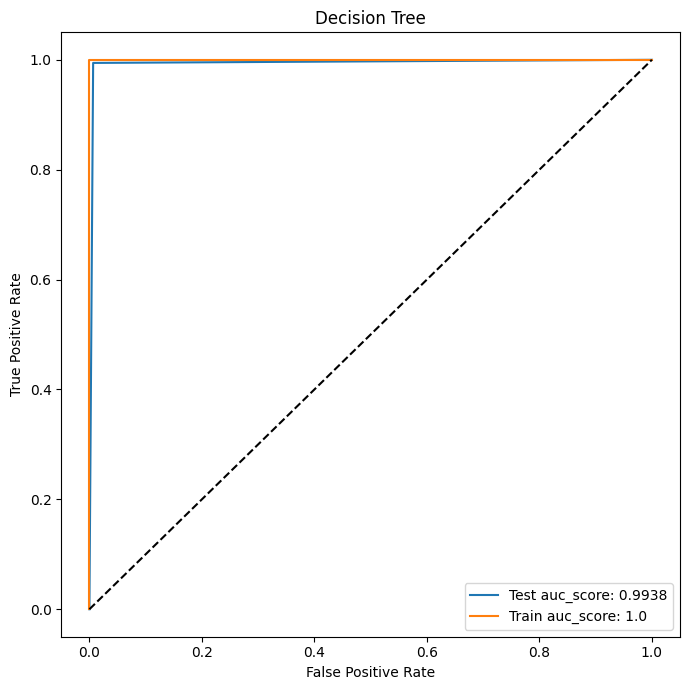

In [65]:
check_metric(y_train, DT_X_train_pred, DT_X_train_pred_prob, 
             y_test, DT_X_test_pred, DT_X_test_pred_prob, 
             title="Decision Tree")

# Count Vectorizer model
- Performed training on MultinomialNB and DecisionTree
- Model performed very well on both

In [101]:
X_train, X_test, y_train, y_test = train_test_split(cv_matrix, df.Target, test_size=0.20, random_state=42)

In [102]:
# Multinomial Naive Bayes Classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = clf.predict(X_test)

In [103]:
X_train_pred = clf.predict(X_train)
X_test_pred = clf.predict(X_test)
X_train_pred_prob = clf.predict_proba(X_train)
X_test_pred_prob = clf.predict_proba(X_test)

In [104]:
from sklearn.metrics import roc_curve, auc

- Test threshold sets the value near 0.16 which might not perform good with train threshold
- Test and Train F1 score works pretty well on both

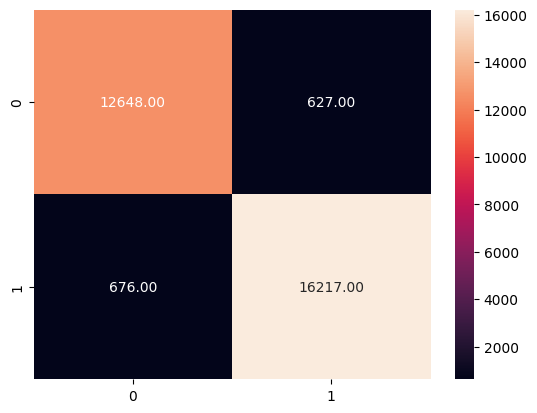

In [105]:
_=sns.heatmap(confusion_matrix(y_train, X_train_pred), annot=True, fmt='.2f')

Test F1 Score:  0.9579059073222498  | Train F1 Score:  0.9613777158609242
Test ROC AUC Score:  0.9517257229578715  | Train ROC AUC Score:  0.9563758933346176
Test Precision Score:  0.956439839886979  | Train Precision Score:  0.962776062692947
Test Recall Score:  0.9593764761454889  | Train Recall Score:  0.9599834250873143
Test Threshold:  0.1640203720305982
Train Threshold:  0.44343625391389724


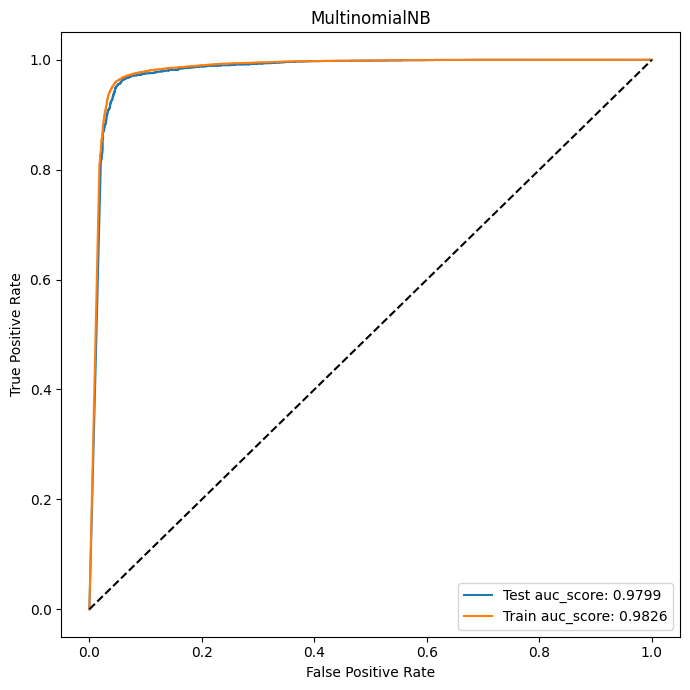

In [80]:
check_metric(y_train, X_train_pred, X_train_pred_prob, 
             y_test, X_test_pred, X_test_pred_prob, 
             title="CV MultinomialNB")

In [81]:
from sklearn.tree import DecisionTreeClassifier

In [82]:
DT_clf = DecisionTreeClassifier()

In [83]:
DT_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [84]:
DT_y_pred = DT_clf.predict(X_test)

In [85]:
DT_X_train_pred = DT_clf.predict(X_train)
DT_X_test_pred = DT_clf.predict(X_test)
DT_X_train_pred_prob = DT_clf.predict_proba(X_train)
DT_X_test_pred_prob = DT_clf.predict_proba(X_test)

Test F1 Score:  0.9961043560382482  | Train F1 Score:  1.0
Test ROC AUC Score:  0.9955079482670088  | Train ROC AUC Score:  1.0
Test Precision Score:  0.995751711116356  | Train Precision Score:  1.0
Test Recall Score:  0.9964572508266415  | Train Recall Score:  1.0
Test Threshold:  1.0
Train Threshold:  1.0


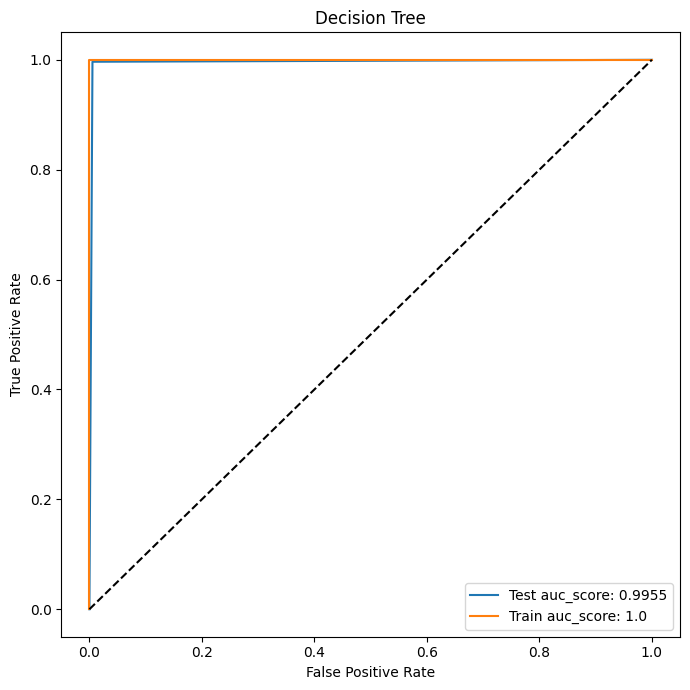

In [86]:
check_metric(y_train, DT_X_train_pred, DT_X_train_pred_prob, 
             y_test, DT_X_test_pred, DT_X_test_pred_prob, 
             title="Decision Tree")

In [108]:
# Create pipeline
from sklearn.pipeline import Pipeline
X_train, X_test, y_train, y_test = train_test_split(clean_df["text"], df.Target, test_size=0.20, random_state=42)
pipeline = Pipeline([
    ('tfidf',TfidfVectorizer(stop_words=stopwords_list)),
    ('clf', MultinomialNB())
])


In [109]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['hammersley', 'further.carrying',
                                             'lubet.', '2017show', 'voldemort',
                                             'say.yeah', 'ecarma',
                                             'kickassnewspod',
                                             'scenario.suppose',
                                             'pic.twitter.comt5vfdfzvre',
                                             'franks', 'jewelryselect',
                                             '2017brock', 'krusing',
                                             'statespecific', 'crapped',
                                             'stirring.one', '122500',
                                             'needs.pirro', 'them.earnhardt',
                                             '2017pic.twitter.comea24zpoohp',
                                             'glossop', '1639',
                                             'flight.instead', 'brenton',
                                             'gulfstream',
                                             'pic.twitter.comgr8oopdqeg',
                                             'questions.this', 'mireille',
                                             'louisclaude', ...])),
                ('clf', MultinomialNB())])

In [110]:
predictions = pipeline.predict(X_test)

- Model pipeline is stored in model location

In [119]:
joblib.dump(pipeline, './model/pipeline_model.pkl')

['./model/pipeline_model.pkl']

# Final Inference
- As the target was to use the text data for binary classification [`True News`, `Fake News`]
- The dataset size was quite huge where the max token length of the text was ~8000 and min was 1
- The dimension of the data was quite higher, I have reduced dimension using frequency distribution
- The text data was having lots of outlier like `URL`, `Combined words`, `Giberish`, `random words`
- All the outliers were handled based on frequency distribution, as the unique words does not have much significance so they can be considered as stopwords
- `DecisionTree` & `Naive Bayes` classifier are used in the training
- These two models have shown high accuracy and F1 score, still there might be possibility of high bias in the data
- `Decision Tree` shows 100% threshold value which sold little unrealistic, so we should move with `Naive Bayes` classifier


# Future Work
- We can reduce dimension with the help of `PCA` or `Truncated SVD` to get better understanding in low dimension
- As of now, even after reducing the dimension still `text` holds the dimension of ~29000 attibutes
- With the help of dimensionality reduction, we can reduce computational cost and reduce feature domancy
- We can in future try out other classification models for getting better insights
